In [2]:
library("lubridate")

In [3]:
library("sandwich")
library("lmtest")
library("car")

In [13]:
library("zoo")
library("xts")
library("forecast")

In [8]:
library("dplyr")


In [9]:
library("broom")

In [10]:
library("ggplot2")

In [43]:
library("stats")

In [34]:
WFData <- read.table("C:/WunderFund_data2.csv", header=TRUE, 
  	sep=",")

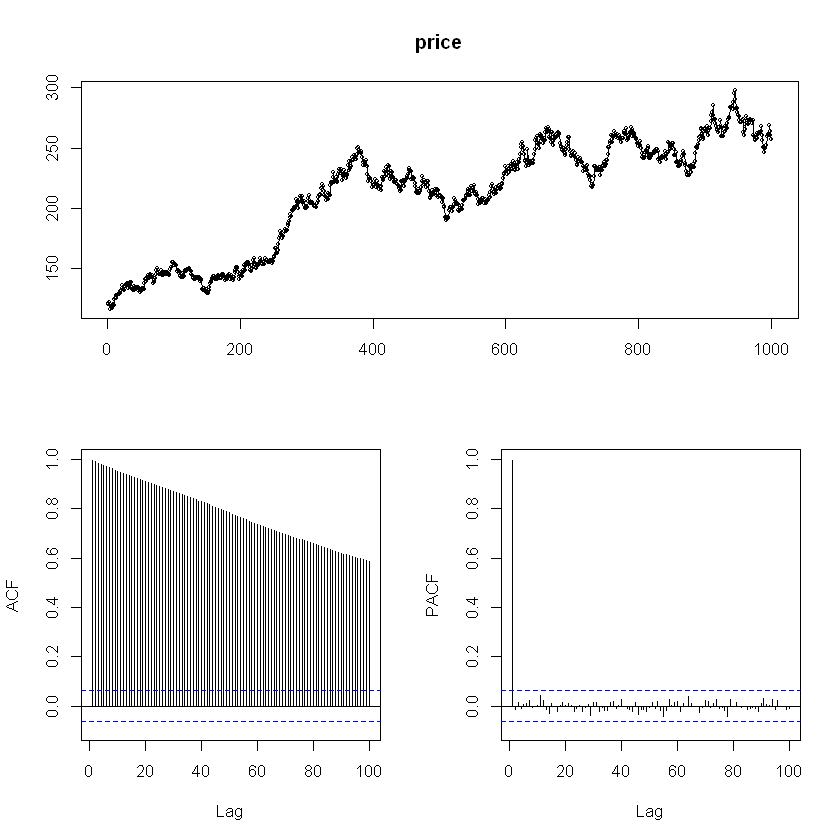

In [35]:
price <- WFData$price
tsdisplay(price, lag.max = 100)

Видно типичные для случайного блуждания графики автокорреляции и частной автокорреляции, чтобы полностью в этом убедиться, нужно посмотреть на разности.

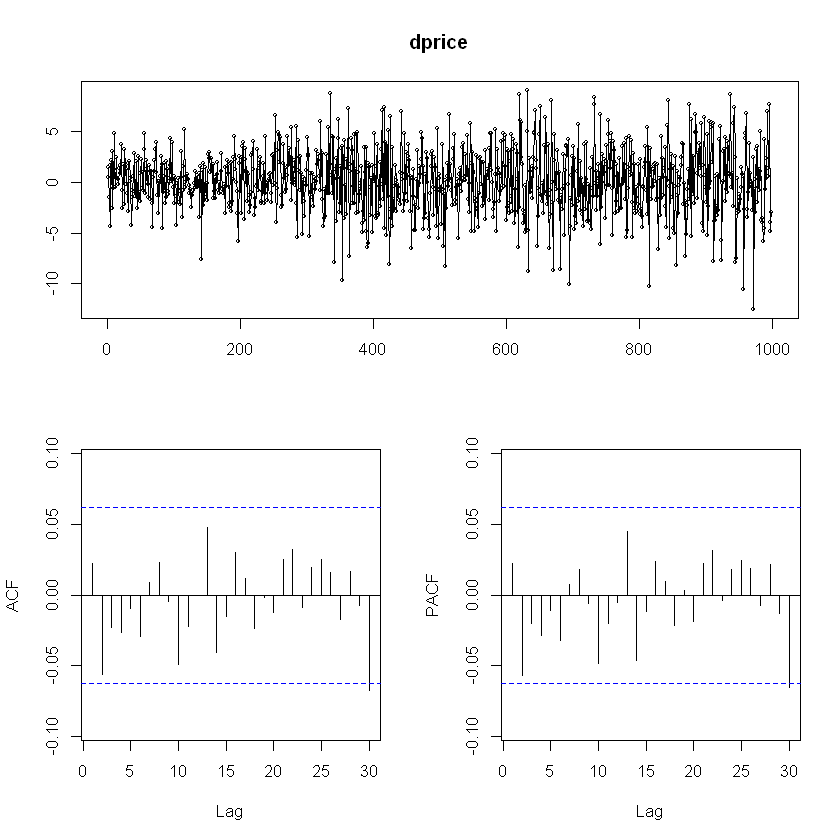

In [36]:
dprice = diff(price)
tsdisplay(dprice)

Приблизим процесс с помощью модели ARIMA.

In [37]:
model_a <- auto.arima(price)
summary(model_a)

Series: price 
ARIMA(0,1,0) with drift         

Coefficients:
       drift
      0.1377
s.e.  0.0987

sigma^2 estimated as 9.743:  log likelihood=-2554.15
AIC=5112.29   AICc=5112.3   BIC=5122.11

Training set error measures:
                      ME     RMSE      MAE          MPE     MAPE      MASE
Training set 0.000119421 3.118228 2.415538 -0.002652657 1.145388 0.9978223
                   ACF1
Training set 0.02258693


Как и ожидалось, случайное блуждание приближается с помощью модели (0, 1, 0), далее посмотрим на прогноз.

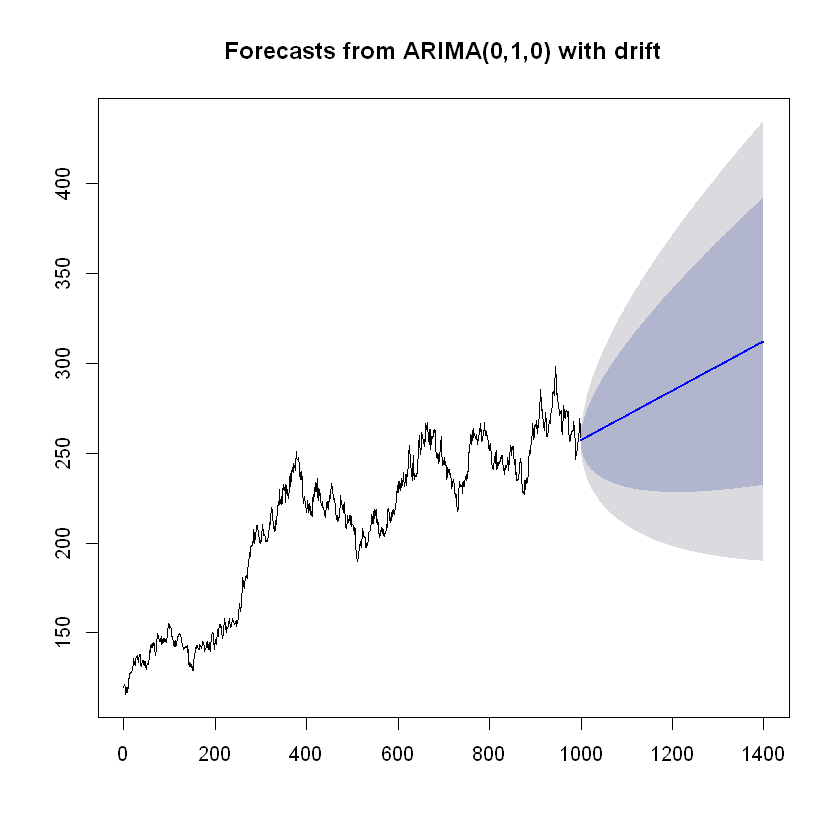

In [40]:
forecast_price <- forecast(model_a, h = 400)
plot(forecast_price)

С помощью данной модели можно смоделировать дальнейшие релизации этого случайного процесса и численно проинтегрировать, чтобы получить ответ на первый вопрос. Будем рассматривать 100000 реализаций. В переменной profit будем хранить результаты всех выигрышных реализаций

In [48]:
N <- 100000
profit <- c()
for (i in 1:N) {
  s = simulate(model_a, nsim = 400)[400]
  if (s > 300) {
    profit <- append(profit, s-300)
  }
}

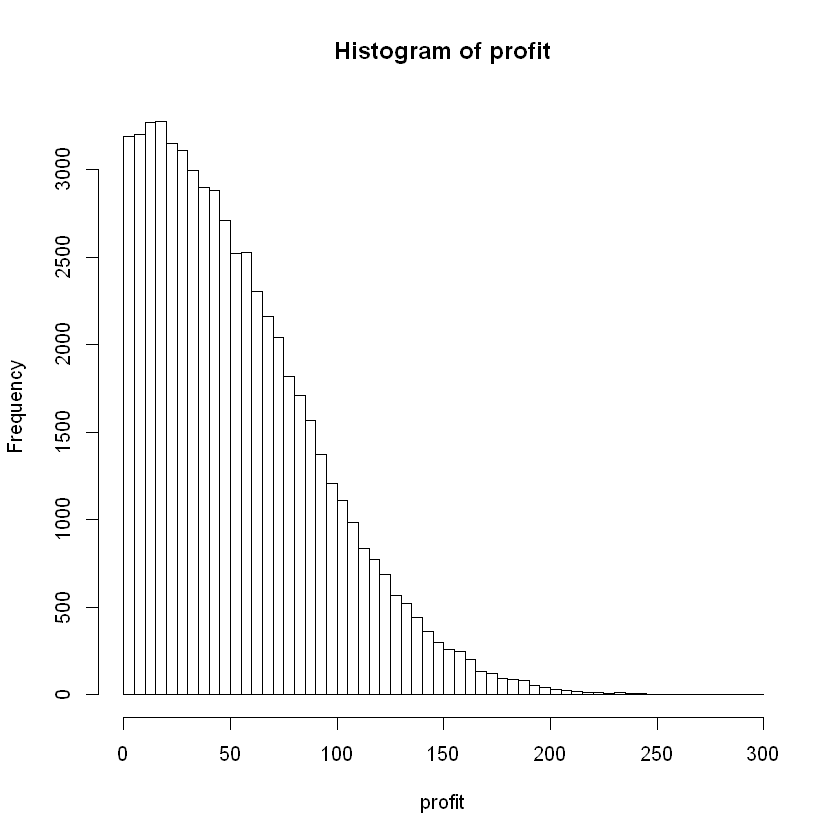

In [51]:
final_hist <- hist(profit, breaks = 100)

Получился ожидаемый результат, распределение похоже на нормальное, так и должно быть в силу принципа инвариантности Донскера-Прохорова. Понятно, что дискретность разбиения вносит погрешность, но эта погрешность на порядок меньше погрешности, вносимой конечным числом симуляций, поэтому я ей пренебрегаю. 

In [53]:
print(final_hist)

$breaks
 [1]   0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
[20]  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
[39] 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280
[58] 285 290 295 300

$counts
 [1] 3190 3202 3270 3278 3150 3110 2995 2898 2882 2709 2522 2529 2304 2165 2040
[16] 1818 1711 1565 1374 1206 1112  982  835  773  688  566  523  442  359  297
[31]  259  246  200  130  122   91   89   83   50   43   31   21   17   12   13
[46]    7   10    7    6    2    1    2    1    0    0    0    0    0    0    1

$density
 [1] 1.101158e-02 1.105300e-02 1.128773e-02 1.131535e-02 1.087350e-02
 [6] 1.073543e-02 1.033846e-02 1.000362e-02 9.948394e-03 9.351214e-03
[11] 8.705708e-03 8.729871e-03 7.953192e-03 7.473377e-03 7.041889e-03
[16] 6.275566e-03 5.906212e-03 5.402233e-03 4.742919e-03 4.162999e-03
[21] 3.838520e-03 3.389772e-03 2.882342e-03 2.668324e-03 2.374912e-03
[26] 1.953779e-03 1.805347e-03 1.525743

Очевидно, что для нахождения искомой величины нужно скалярно умножить вектор **final_hist.counts** на вектор **final_hist.mids** и разделить на **N**

In [68]:
pr <- ((final_hist$counts%*%final_hist$mids)/N)[1,1]

In [69]:
print(pr)

[1] 31.57372


Ну а погрешность метода находим с помощью многократного нахождения значения **pr**